In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist

# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape the input data to match CNN input shape (add a channel dimension)
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

# Define the model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

# Save the trained model
model.save('mnist_cnn_model.h5')


2024-02-14 21:32:46.934475: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-14 21:33:09.572319: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/5
938/938 [==============================] - 11s 11ms/step - loss: 0.1786 - accuracy: 0.9473 - val_loss: 0.0543 - val_accuracy: 0.9833
Epoch 2/5
938/938 [==============================] - 8s 9ms/step - loss: 0.0533 - accuracy: 0.9835 - val_loss: 0.0467 - val_accuracy: 0.9849
Epoch 3/5
938/938 [==============================] - 8s 8ms/step - loss: 0.0374 - accuracy: 0.9880 - val_loss: 0.0389 - val_accuracy: 0.9877
Epoch 4/5
938/938 [==============================] - 8s 8ms/step - loss: 0.0289 - accuracy: 0.9910 - val_loss: 0.0362 - val_accuracy: 0.9892
Epoch 5/5
938/938 [==============================] - 8s 8ms/step - loss: 0.0222 - accuracy: 0.9928 - val_loss: 0.0393 - val_accuracy: 0.9881


/cvmfs/sft.cern.ch/lcg/views/LCG_105/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
# load model
from tensorflow.keras.models import load_model
import numpy as np

model = load_model('mnist_cnn_model.h5')

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 64)                1

In [14]:
def representative_dataset_gen():
    for _ in range(num_calibration_steps):
        # Generate or load representative data samples
        data_sample = np.random.rand(1, 28, 28, 1)  # Sample input data
        yield [data_sample.astype(np.float32)]

In [15]:
# Define the number of calibration steps
num_calibration_steps = 100

# Convert the model to a TensorFlow Lite compatible format with int8 quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/sraj/tmpn5zd6wyc/assets


INFO:tensorflow:Assets written to: /tmp/sraj/tmpn5zd6wyc/assets
/cvmfs/sft.cern.ch/lcg/views/LCG_105/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-02-14 21:40:14.174976: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-02-14 21:40:14.175013: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-02-14 21:40:14.175218: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/sraj/tmpn5zd6wyc
2024-02-14 21:40:14.176212: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-02-14 21:40:14.176228: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/sraj/tmpn5zd6wyc
2024-02-14 21:40:14.179006: I tensorflow/cc/saved_model/loader.cc:231]

In [16]:
# Save the quantized model
with open('quantized_mnist_model.tflite', 'wb') as f:
    f.write(tflite_model)

In [17]:
# load the quantized model
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [20]:
input_details

[{'name': 'serving_default_conv2d_input:0',
  'index': 0,
  'shape': array([ 1, 28, 28,  1], dtype=int32),
  'shape_signature': array([-1, 28, 28,  1], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (0.003921540919691324, 0),
  'quantization_parameters': {'scales': array([0.00392154], dtype=float32),
   'zero_points': array([0], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [21]:
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 19,
  'shape': array([ 1, 10], dtype=int32),
  'shape_signature': array([-1, 10], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (0.00390625, 0),
  'quantization_parameters': {'scales': array([0.00390625], dtype=float32),
   'zero_points': array([0], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [22]:

input_data = np.random.rand(1, 28, 28, 1)

# Inference
interpreter.set_tensor(input_details[0]['index'], input_data.astype(np.uint8))
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])


In [23]:
print("Inference result:", output_data)


Inference result: [[27 35 24 20 26 26 25 26 24 23]]


In [24]:
## Dynamic Range Quantiation

In [28]:
# Load the trained model
model = tf.keras.models.load_model('mnist_cnn_model.h5')

# Convert the model to a TensorFlow Lite compatible format with dynamic range quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()


INFO:tensorflow:Assets written to: /tmp/sraj/tmp8x7drts5/assets


INFO:tensorflow:Assets written to: /tmp/sraj/tmp8x7drts5/assets
2024-02-14 21:50:59.007776: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-02-14 21:50:59.007909: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-02-14 21:50:59.008110: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/sraj/tmp8x7drts5
2024-02-14 21:50:59.009167: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-02-14 21:50:59.009186: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/sraj/tmp8x7drts5
2024-02-14 21:50:59.012785: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-02-14 21:50:59.050442: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/sraj/tmp8x7drts5
2024-02-14 21:50:59.066991: I tensorflow/cc/saved_model/loade

In [29]:
# Save the quantized model
with open('quantized_mnist_model_dynamic.tflite', 'wb') as f:
    f.write(tflite_model)


# Float16 quantization

In [30]:
# Load the trained model
model = tf.keras.models.load_model('mnist_cnn_model.h5')

# Convert the model to a TensorFlow Lite compatible format with dynamic range quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/sraj/tmpsxjeuhu6/assets


INFO:tensorflow:Assets written to: /tmp/sraj/tmpsxjeuhu6/assets
2024-02-14 21:54:13.443474: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-02-14 21:54:13.443588: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-02-14 21:54:13.443785: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/sraj/tmpsxjeuhu6
2024-02-14 21:54:13.444851: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-02-14 21:54:13.444872: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/sraj/tmpsxjeuhu6
2024-02-14 21:54:13.447841: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-02-14 21:54:13.488121: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/sraj/tmpsxjeuhu6
2024-02-14 21:54:13.499961: I tensorflow/cc/saved_model/loade

In [31]:
# Save the quantized model
with open('quantized_mnist_model_fp16.tflite', 'wb') as f:
    f.write(tflite_model)


In [38]:
ls -lh

total 2.5M
-rw-r--r--. 1 sraj zh  745 Feb 14 19:04 INT8_quantization_Pytorch.ipynb
-rw-r--r--. 1 sraj zh  21K Feb 14 22:00 INT8_quantization_Tf.ipynb
-rw-r--r--. 1 sraj zh  68K Feb 14 21:37 load-pytorch.ipynb
-rw-r--r--. 1 sraj zh 1.5M Feb 14 21:33 mnist_cnn_model.h5
-rw-r--r--. 1 sraj zh 8.1K Feb 14 18:52 Quantization_understanding.ipynb
-rw-r--r--. 1 sraj zh 127K Feb 14 21:51 quantized_mnist_model_dynamic.tflite
-rw-r--r--. 1 sraj zh 243K Feb 14 21:54 quantized_mnist_model_fp16.tflite
-rw-r--r--. 1 sraj zh 127K Feb 14 21:41 quantized_mnist_model.tflite
-rw-r--r--. 1 sraj zh 480K Feb 14 21:59 unquantized_mnist_model.tflite


Convert the unquantized model

In [36]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/sraj/tmpum3qpyqe/assets


INFO:tensorflow:Assets written to: /tmp/sraj/tmpum3qpyqe/assets
2024-02-14 21:58:57.368302: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-02-14 21:58:57.368417: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-02-14 21:58:57.368626: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/sraj/tmpum3qpyqe
2024-02-14 21:58:57.369673: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-02-14 21:58:57.369694: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/sraj/tmpum3qpyqe
2024-02-14 21:58:57.373588: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-02-14 21:58:57.416144: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/sraj/tmpum3qpyqe
2024-02-14 21:58:57.427755: I tensorflow/cc/saved_model/loade

In [37]:
with open('unquantized_mnist_model.tflite', 'wb') as f:
    f.write(tflite_model)


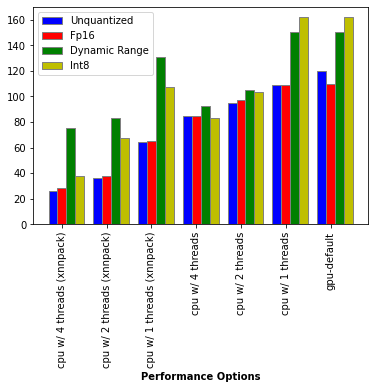

In [39]:
import matplotlib.pyplot as plt

# Data for unquantized model
unquantized_data = {
    "cpu w/ 4 threads (xnnpack)": 25.8211,
    "cpu w/ 2 threads (xnnpack)": 36.2405,
    "cpu w/ 1 threads (xnnpack)": 64.7086,
    "cpu w/ 4 threads": 84.4446,
    "cpu w/ 2 threads": 94.5954,
    "cpu w/ 1 threads": 108.926,
    "gpu-default": 120.178
}

# Data for Fp16 quantization
fp16_data = {
    "cpu w/ 4 threads (xnnpack)": 28.3489,
    "cpu w/ 2 threads (xnnpack)": 37.655,
    "cpu w/ 1 threads (xnnpack)": 64.8064,
    "cpu w/ 4 threads": 84.8022,
    "cpu w/ 2 threads": 97.2019,
    "cpu w/ 1 threads": 108.768,
    "gpu-default": 109.432
}

# Data for Dynamic Range quantization
dynamic_range_data = {
    "cpu w/ 4 threads (xnnpack)": 75.4052,
    "cpu w/ 2 threads (xnnpack)": 82.9918,
    "cpu w/ 1 threads (xnnpack)": 130.894,
    "cpu w/ 4 threads": 92.6607,
    "cpu w/ 2 threads": 105.124,
    "cpu w/ 1 threads": 150.422,
    "gpu-default": 150.063
}

# Data for Int8 quantization
int8_data = {
    "cpu w/ 4 threads (xnnpack)": 37.4216,
    "cpu w/ 2 threads (xnnpack)": 67.3639,
    "cpu w/ 1 threads (xnnpack)": 107.24,
    "cpu w/ 4 threads": 83.1904,
    "cpu w/ 2 threads": 103.453,
    "cpu w/ 1 threads": 161.806,
    "gpu-default": 161.96
}

# Extract labels and values
labels = list(unquantized_data.keys())
unquantized_values = list(unquantized_data.values())
fp16_values = list(fp16_data.values())
dynamic_range_values = list(dynamic_range_data.values())
int8_values = list(int8_data.values())

# Set width of bars
bar_width = 0.2

# Set position of bar on X axis
r1 = range(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Make the plot
plt.bar(r1, unquantized_values, color='b', width=bar_width, edgecolor='grey', label='Unquantized')
plt.bar(r2, fp16_values, color='r', width=bar_width, edgecolor='grey', label='Fp16')
plt.bar(r3, dynamic_range_values, color='g', width=bar_width, edgecolor='grey', label='Dynamic Range')
plt.bar(r4, int8_values, color='y', width=bar_width, edgecolor='grey', label='Int8')

# Add xticks on the middle of the group bars
plt.xlabel('Performance Options', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(labels))], labels, rotation=90)

# Create legend & Show graphic
plt.legend()
plt.show()
